In [410]:
from pysat.formula import CNF
from pysat.solvers import Solver
from sympy.logic.boolalg import Or, And, Not, to_cnf
from sympy import symbols
from pprint import pprint

In [411]:
def flatten(s):
    return [x for xs in s for x in xs]

def len_flat(s):
    return len(flatten(s))

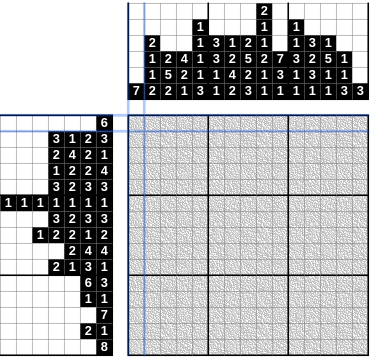

In [412]:
rows = 15
cols = 15
cols_seqs = ((7,),(2,1,1,2),(2,5,2),(4,2,1),(1,1,1,1,3),(3,3,1,1),(1,2,4,2),(2,5,2,3),(2,1,1,2,1,1),(7,3,1),(1,1,3,1,1),(3,2,3,1),(1,5,1,1),(1,1,3),(3,))
num_col_seqs = len_flat(cols_seqs)
rows_seqs = ((6,),(3,1,2,3),(2,4,2,1),(1,2,2,4),(3,2,3,3),(1,1,1,1,1,1,1),(3,2,3,3),(1,2,2,1,2),(2,4,4),(2,1,3,1),(6,3),(1,1),(7,),(2,1),(8,))
num_row_seqs = len_flat(rows_seqs)

# The first variables, are for each of the col seqs, where do they start.
# Then where do the rows seqs start. Lastly, whether each cell is black or white
num_vars = rows * cols + num_col_seqs * rows + num_row_seqs * cols

x = symbols(f"x0:{num_vars}")

cols_seqs_index = 0
rows_seqs_index = num_col_seqs * rows
cells_index = num_col_seqs * rows + num_row_seqs * cols

def cell_index(x, y):
    return x * cols + y + cells_index

In [413]:
non_cnf_formula = And()
for i in range(num_col_seqs):
    non_cnf_formula &= Or(*[x[j] for j in range(i * rows, (i+1)*rows)])

for i in range(num_row_seqs):
    non_cnf_formula &= Or(*[x[j] for j in range(rows_seqs_index + i * cols, rows_seqs_index + (i+1)*cols)])

In [414]:
# Now each seq starting from some index i, implies that the next sequence can't start from the 
# start of the column up to this index i, and can't start from index i forward the amount of the 
# sequence, and another 1 cell for spacing
rule = And()
var_index = 0
for col_seqs in cols_seqs:
    # The last seq in the column doesn't say anything on the next ones
    for seq in col_seqs[:-1]:
        # The var that the next seq is starting in row 0
        next_seq_index = var_index + rows
        for irow in range(rows):
            # If the current seq starts at row <irow>, the next seq can't start from 0 to <irow + seq_length>
            next_seq_can_start_from = min(irow + seq + 1, rows)
            
            rule &= And(*[x[var_index] >> ~x[next_seq_index + j] for j in range(0,next_seq_can_start_from)])
            # The var that the seq <seqi> is starting in row <i> 
            var_index += 1
    if col_seqs:
        # The last seq can't be in the last cells in the col
        last_seq = col_seqs[-1]
        rule &= And(*[~x[var_index + j] for j in range(rows-last_seq+1, rows)])
        # Advance to the var in the next col
        var_index += rows

non_cnf_formula &= rule

In [415]:
rule = And()
for row_seqs in rows_seqs:
    # The last seq in the column doesn't say anything on the next ones
    for seq in row_seqs[:-1]:
        # The var that the next seq is starting in col 0
        next_seq_index = var_index + cols
        for icol in range(cols):
            # If the current seq starts at col <icol>, the next seq can't start from 0 to <icol + seq_length>
            next_seq_can_start_from = min(icol + seq + 1, cols)
            
            rule &= And(*[x[var_index] >> ~x[next_seq_index + j] for j in range(0,next_seq_can_start_from)])
            # The var that the seq <seqi> is starting in col <i> 
            var_index += 1
    if row_seqs:
        # The last seq can't be in the last cells in the row
        last_seq = row_seqs[-1]
        rule &= And(*[~x[var_index + j] for j in range(cols-last_seq+1, cols)])
        # Advance to the var in the next col
        var_index += cols

non_cnf_formula &= rule

In [416]:
# rule A - Column sequences starting are implying cells are black, and one empty cell
rule = And()
var_index = 0
for icol, col_seqs in enumerate(cols_seqs):
    for seq in col_seqs:
        for irow in range(rows):
            if (irow + seq > rows):
                # The sequence cannot start here, it doesn't have enough space
                var_index += 1
                continue
            # Current seq starts at <irow>. This implies cells are black/white
            rule &= x[var_index] >> And(*[x[cell_index(y, icol)] for y in range(irow, irow+seq)])
            if (irow+seq < rows):
                # Add a space cell after the seq
                rule &= x[var_index] >> ~x[cell_index(irow + seq, icol)]
            var_index += 1

non_cnf_formula &= rule

In [417]:
# rule B - Row sequences starting are implying cells are black, and one empty cell
rule = And()
var_index = rows_seqs_index
for irow, row_seqs in enumerate(rows_seqs):
    for seq in row_seqs:
        for icol in range(cols):
            if (icol + seq > cols):
                # The sequence cannot start here, it doesn't have enough space
                var_index += 1
                continue
            # Current seq starts at <icol>. This implies cells are black/white
            rule &= x[var_index] >> And(*[x[cell_index(irow, y)] for y in range(icol, icol+seq)])
            if (icol+seq < cols):
                # Add a space cell after the seq
                rule &= x[var_index] >> ~x[cell_index(irow, icol + seq)]
            var_index += 1

non_cnf_formula &= rule

In [418]:
# rule A - empty spaces before the first seq every col
rule = And()
var_index = 0
for icol, col_seqs in enumerate(cols_seqs):
    first_seq = col_seqs[0]
    for irow in range(1, rows):
        # The seq starting at irow, implies that the previous cells are empty 
        rule &= x[var_index+irow] >> And(*[~x[cell_index(i, icol)] for i in range(0,irow)])
    var_index += len(col_seqs) * rows

non_cnf_formula &= rule

In [419]:
# rule B - empty spaces before the first seq every col
rule = And()
var_index = rows_seqs_index
for irow, row_seqs in enumerate(rows_seqs):
    first_seq = row_seqs[0]
    for icol in range(1, cols):
        # The seq starting at icol, implies that the previous cells are empty 
        rule &= x[var_index+icol] >> And(*[~x[cell_index(irow, i)] for i in range(0,icol)])
    var_index += len(row_seqs) * cols

non_cnf_formula &= rule

In [420]:
# rule A - empty spaces after the last seq every col
rule = And()
var_index = 0
for icol, col_seqs in enumerate(cols_seqs):
    last_seq = col_seqs[-1]
    var_index += len(col_seqs) * rows - rows
    for irow in range(0, rows - last_seq):
        # The seq starting at irow, implies that the previous cells are empty 
        rule &= x[var_index+irow] >> And(*[~x[cell_index(i, icol)] for i in range(irow+last_seq,rows)])
    var_index += rows

non_cnf_formula &= rule

In [421]:
# rule B - empty spaces after the last seq every row
rule = And()
var_index = rows_seqs_index
for irow, row_seqs in enumerate(rows_seqs):
    last_seq = row_seqs[-1]
    var_index += len(row_seqs) * cols - cols
    for icol in range(0, cols - last_seq):
        # The seq starting at icol, implies that the previous cells are empty 
        # print(irow,icol,var_index+icol,cell_index(irow,icol+last_seq))
        rule &= x[var_index+icol] >> And(*[~x[cell_index(irow, i)] for i in range(icol+last_seq,cols)])
    var_index += cols

non_cnf_formula &= rule

In [422]:
# rule A - Fill empty spaces in between each 2 sequences
rule = And()
var_index = 0
for icol, col_seqs in enumerate(cols_seqs):
    for iseq, seq in enumerate(col_seqs[:-1]):
        next_var_index = var_index + rows

        for seq_start_row in range(rows):
            for next_var_row in range(seq_start_row + seq + 2, rows):
                var_start_index = var_index + seq_start_row
                next_var_start_index = next_var_index + next_var_row
                rule &= And(x[var_start_index] & x[next_var_start_index]) >> And(*[~x[cell_index(row, icol)] for row in range(seq_start_row+seq, next_var_row)])
        var_index += rows
    var_index += rows

non_cnf_formula &= rule

In [423]:
# rule B - Fill empty spaces in between each 2 sequences in rows
# For some reason I see that this was never needed in any of the griddlers I've tested. I'm not sure why
# Since it's the heaviest rule, I rather avoid it if it's not necessary. I'll add it if I see a puzzle which needs it

In [424]:
# Convert to CNF
cnf_formula = to_cnf(non_cnf_formula)

In [425]:
def sympy_to_pysat(cnf_expr, mapping):
    def traverse(expr):
        if isinstance(expr, And):
            return [traverse(arg) for arg in expr.args]
        elif isinstance(expr, Or):
            return [traverse(arg) for arg in expr.args]
        elif isinstance(expr, Not):
            return -mapping[expr.args[0]]
        else:  # It's a variable
            return mapping[expr]
    
    # Flatten the AND clauses into a list of lists
    return [clause if isinstance(clause, list) else [clause] for clause in traverse(cnf_expr)]

# Convert to pysat format
variable_mapping = {var: idx + 1 for idx, var in enumerate(x)}
pysat_cnf = sympy_to_pysat(cnf_formula, variable_mapping)

In [426]:
# create a satisfiable CNF formula "(-x1 ∨ x2) ∧ (-x1 ∨ -x2)":
cnf = CNF(from_clauses=pysat_cnf)

# create a SAT solver for this formula:
with Solver(bootstrap_with=cnf) as solver:
    # 1.1 call the solver for this formula:
    print('formula is', f'{"s" if solver.solve() else "uns"}atisfiable')

    # 1.2 the formula is satisfiable and so has a model:

    solution = [x - 1 if x > 0 else x + 1 for x in solver.get_model()]
    # print('and the model is:', solution)

formula is satisfiable


In [427]:
d = solution[cells_index:]
for i in range(rows):
    for j in range(cols):
        val = d[i*cols+j]
        sign = val > 0
        print("X" if sign else "_", end=" ")
        # print(val, end=" ")
    print()

_ _ X X X X X X _ _ _ _ _ _ _ 
_ X X X _ X _ X X _ X X X _ _ 
X X _ X X X X _ X X _ X _ _ _ 
X _ X X _ _ X X _ X X X X _ _ 
X X X _ X X _ X X X _ _ X X X 
X _ X _ _ X _ X _ X _ _ X _ X 
X X X _ X X _ X X X _ _ X X X 
X _ X X _ _ X X _ X _ X X _ _ 
X X _ X X X X _ X X X X _ _ _ 
_ X X _ X _ X X X _ X _ _ _ _ 
_ _ X X X X X X _ X X X _ _ _ 
_ _ _ _ _ _ _ _ _ X _ X _ _ _ 
_ _ _ _ _ _ _ X X X X X X X _ 
_ _ _ _ _ _ X X _ _ _ _ _ X _ 
_ _ _ _ _ _ X X X X X X X X _ 
